# Import libraries

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline



# Load the data

In [2]:
train_data = np.genfromtxt('Train_Set.csv', delimiter=',', dtype=str, skip_header=1)
test_data = np.genfromtxt('Test_Set.csv', delimiter=',', dtype=str, skip_header=1)

def convert_labels(data):
    labels = data[:, -1]
    labels = np.where(labels == 'healthy', 0, 1)
    features = data[:, :-1].astype(float)
    return features, labels

X_train, y_train = convert_labels(train_data)
X_test, y_test = convert_labels(test_data)

# Feature Scaling


In [3]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Preprocess the data

### Feature Reduction: PCA

In [4]:
pca = PCA(n_components = 20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(f"Number of components retained by PCA: {X_train.shape[1]}")

Number of components retained by PCA: 20



# Tuning Hyperparameter For Each Model Using GridSearchCV


We use a Pipeline with GridSearchCV so that SMOTE is applied only on the training folds within each cross-validation split

### Define Specificity

In [5]:
# Define the specificity scoring function
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Create the custom specificity scorer
scoring = {'specificity': make_scorer(specificity_score)}

### Search for the best hyperparameter for Decision Tree Clasification

In [6]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 10, 20, 30, 40],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 5],
    'dt__max_features': [None, 'sqrt', 'log2'],
    'dt__class_weight': [None, 'balanced']
}

# Create the Pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE()), # smote done for each fold
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Set up the GridSearchCV to score based on specificity only
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='specificity',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best parameters and best specificity score
best_params_DT = grid_search.best_params_
best_specificity = grid_search.best_score_

# Print the best parameters and best specificity score
print("Best Parameters:", best_params_DT)
print("Best Specificity Score (Cross-Validation):", best_specificity)


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best Parameters: {'dt__class_weight': None, 'dt__criterion': 'entropy', 'dt__max_depth': 20, 'dt__max_features': None, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 2}
Best Specificity Score (Cross-Validation): 0.7


In [7]:
# Define the parameter grid for GridSearchCV
param_grid = {
   'rf__max_depth': [2 ,5, 10, 15],
   'rf__n_estimators': [50, 100, 150],
   'rf__min_samples_split': [10, 15, 20],
   'rf__min_samples_leaf': [5, 8, 10],
   'rf__max_features': ['sqrt', 0.5, 0.75],
   'rf__bootstrap': [True]
}

# Create the Pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE()), # smote done for each fold
    ('rf', RandomForestClassifier(random_state=42))
])

# Set up the GridSearchCV to score based on specificity only
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           scoring=scoring,
                           refit='specificity',  # Refitting using the specificity score
                           cv=5,  # 5-fold cross-validation
                           verbose=2,  # Verbosity level
                           n_jobs=-1)  # Use all available cores

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best parameters and best specificity score
best_params_RF = grid_search.best_params_
best_specificity = grid_search.best_score_

# Print the best parameters and best specificity score
print("Best Parameters:", best_params_RF)
print("Best Specificity Score (Cross-Validation):", best_specificity)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 2, 'rf__max_features': 0.75, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 15, 'rf__n_estimators': 100}
Best Specificity Score (Cross-Validation): 0.7833333333333334


### Search for the best hyperparameter for Logistic Regression Classification

In [8]:
# Define a valid parameter grid including the C parameter for regularization strength
param_grid = [
    {'lr__solver': ['lbfgs'], 'lr__penalty': ['l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]},
    {'lr__solver': ['liblinear'], 'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]},
    {'lr__solver': ['saga'], 'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]},
    {'lr__solver': ['saga'], 'lr__penalty': ['elasticnet'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__l1_ratio': [0.1, 0.5, 0.9]},
    {'lr__solver': ['sag'], 'lr__penalty': ['l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]}
]

# Create a pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE()),
    ('lr', LogisticRegression(random_state=42))
])

# Set up GridSearchCV to use the specificity score
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=scoring,
                           refit='specificity',  # Refitting using the specificity score
                           cv=5,  # 5-fold cross-validation
                           verbose=2,  # Verbosity level
                           n_jobs=-1)  # Use all available cores

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Extract the best parameters and the best specificity score
best_params_LR = grid_search.best_params_
best_specificity = grid_search.best_score_

# Print the best parameters and best specificity score
print("Best Parameters:", best_params_LR)
print("Best Specificity Score (Cross-Validation):", best_specificity)


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best Specificity Score (Cross-Validation): 0.9


### Search for the best hyperparameter for Random Forest Classification

### Search for the best hyperparameter for SVM

In [9]:
# Define the SVM model with balanced class weights
svm = SVC(class_weight='balanced')

# Set up the parameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Use GridSearchCV with the custom scorer
grid_search = GridSearchCV(estimator=svm,
                           param_grid=param_grid,
                           scoring=scoring,
                           refit='specificity',
                           cv=5,
                           verbose=2,
                           n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Extract the best parameters and the best specificity score
best_params_SVM = grid_search.best_params_
best_specificity = grid_search.best_score_

# Print the best parameters and best specificity score
print("Best Parameters:", best_params_SVM)
print("Best Specificity Score (Cross-Validation):", best_specificity)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Specificity Score (Cross-Validation): 0.85


# Modelling and Evaluation

In [11]:
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

### Test the model with the best parameter

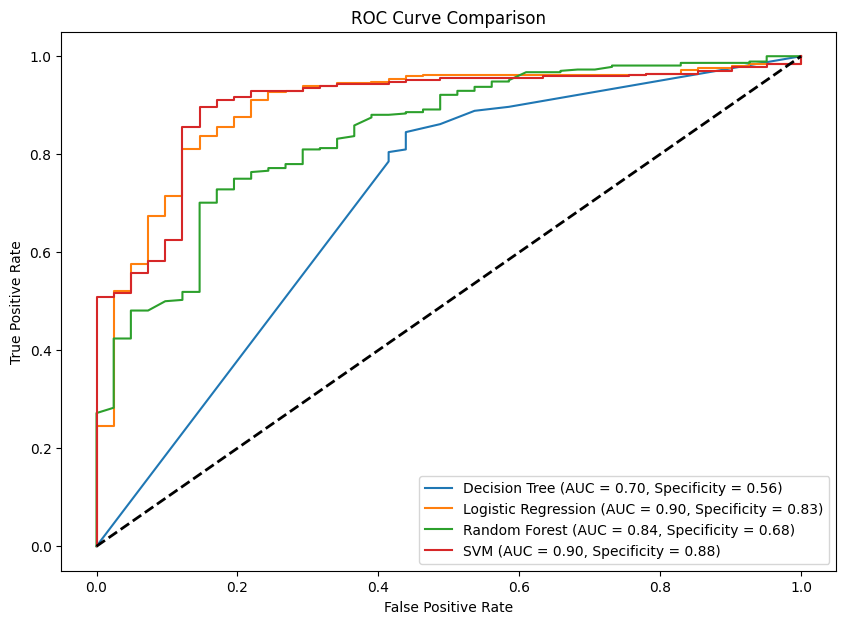

In [12]:
best_params_RF_corrected = {key.replace('rf__', ''): value for key, value in best_params_RF.items()}
best_params_DT_corrected = {key.replace('dt__', ''): value for key, value in best_params_DT.items()}
best_params_LR_corrected = {key.replace('lr__', ''): value for key, value in best_params_LR.items()}

# Initialize models with the corrected parameters
rf = RandomForestClassifier(random_state=42, **best_params_RF_corrected)
dt = DecisionTreeClassifier(random_state=42, **best_params_DT_corrected)
lr = LogisticRegression(random_state=42, **best_params_LR_corrected)
svm = SVC(**best_params_SVM, probability = True, class_weight = "balanced")


# Fit models
lr.fit(X_train_SMOTE, y_train_SMOTE)
rf.fit(X_train_SMOTE, y_train_SMOTE)
dt.fit(X_train_SMOTE, y_train_SMOTE)
svm.fit(X_train, y_train)

# Get predictions and probabilities
models = {'Decision Tree': dt, 'Logistic Regression': lr, 'Random Forest': rf, 'SVM': svm}
plt.figure(figsize=(10, 7))

for name, model in models.items():
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_proba)  # ROC curve
    roc_auc = auc(fpr, tpr)  # AUC score
    specificity = tn / (tn + fp)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}, Specificity = {specificity:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

